# 03_GriddedDiagnostics_Divergence_Isotachs_ERA5
### In this notebook, we'll compute and plot the divergence and magnitude of the wind at a particular isobaric surface.

# <span style="color:purple">0) Imports </span>

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, regional extent, vertical levels, and access the ERA5</span>

<div class="alert alert-danger">Restrict your date range to no more than 7 days!</div>

In [2]:
# Areal extent
lonW = -100
lonE = -60
latS = 20
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2

# Recall that in ERA5, longitudes run between 0 and 360, not -180 and 180
if (lonW < 0 ):
    lonW = lonW + 360
if (lonE < 0 ):
    lonE = lonE + 360
    
expand = 1
latRange = np.arange(latS - expand,latN + expand,.25) # expand the data range a bit beyond the plot range
lonRange = np.arange((lonW - expand),(lonE + expand),.25) # Need to match longitude values to those of the coordinate variable

# Vertical level specification
pLevel = 300
levStr = f'{pLevel}'

startYear = 1979
startMonth = 2
startDay = 18
startHour = 18
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 1979
endMonth = 2
endDay = 19
endHour = 12
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)

delta_time = endDateTime - startDateTime
time_range_max = 7*86400

if (delta_time.total_seconds() > time_range_max):
        raise RuntimeError("Your time range must not exceed 7 days. Go back and try again.")

In [3]:
Wb2EndDate = dt(2023,1,10)
if (endDateTime <= Wb2EndDate):
    ds = xr.open_dataset(
     'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721.zarr', 
     chunks={'time': 48},
     consolidated=True,
     engine='zarr'
)
else: 
    import glob, os
    input_directory = '/free/ktyle/era5'
    files = glob.glob(os.path.join(input_directory,'*.nc'))
    varDict = {'valid_time': 'time', 
               'pressure_level': 'level',
               'msl': 'mean_sea_level_pressure',
               'q': 'specific_humidity',
               't': 'temperature',
               'u': 'u_component_of_wind',
               'v': 'v_component_of_wind',
               'w': 'vertical_velocity',
               'z': 'geopotential'}
    dimDict = {'valid_time': 'time',
               'pressure_level': 'level'}
    ds = xr.open_mfdataset(files).rename_dims(dimDict).rename_vars(varDict)

Examine the `Dataset`

In [4]:
ds

<xarray.Dataset> Size: 47TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/50)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...                                                ...
    v_component_of_wind                               (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(48, 13, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(48, 13, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [5]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6h")
dateList

DatetimeIndex(['1979-02-18 18:00:00', '1979-02-19 00:00:00',
               '1979-02-19 06:00:00', '1979-02-19 12:00:00'],
              dtype='datetime64[ns]', freq='6h')

We will display geopotential height, isotachs, wind barbs, and divergence, so pick the relevant variables.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [6]:
# Data variable selection
U = ds['u_component_of_wind'].sel(time=dateList,level=pLevel,latitude=latRange,longitude=lonRange).compute()
V = ds['v_component_of_wind'].sel(time=dateList,level=pLevel,latitude=latRange,longitude=lonRange).compute()
Z = ds['geopotential'].sel(time=dateList,level=pLevel,latitude=latRange,longitude=lonRange).compute()

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [7]:
lats = Z.latitude
lons = Z.longitude

## We have two diagnostics to calculate: windspeed and divergence.
### First, windspeed. See https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_speed.html 

In [8]:
# Calculate windspeed and convert to knots.
WSPD = mpcalc.wind_speed(U, V)
WSPD = WSPD.metpy.convert_units('kts')

We will draw filled contours of isotachs every 25 knots beginning at 100 knots.

In [9]:
wspdInc = 25
wspdContours = np.arange (100, 200, wspdInc)

### Next, divergence. See https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.divergence.html 

In [10]:
div = mpcalc.divergence(U, V)

#### Print out the value of divergence at one of the gridpoints. Since it still has units attached, we get a nice sense as to how it scales.

In [11]:
div.sel(latitude=40, longitude=285) # remember, ERA5 represents W Hemisphere longitudes from 180 to 360

<xarray.DataArray (time: 4)> Size: 32B
<Quantity([5.46305718e-05 8.04297043e-06 1.10157867e-05 9.92256900e-05], '1 / second')>
Coordinates:
    latitude   float32 4B 40.0
    level      int64 8B 300
    longitude  float32 4B 285.0
  * time       (time) datetime64[ns] 32B 1979-02-18T18:00:00 ... 1979-02-19T1...

### Derived fields such as divergence can be quite messy looking. Apply the Gaussian smoother, which MetPy provides, to deal with this. 

In [12]:
sigma = 7.0 # this depends on how noisy your data is, adjust as necessary

divSmooth = mpcalc.smooth_gaussian(div, sigma)

### Scale these values up by 1e6 (or 1 * 10**6, or 1,000,000) and find the min/max values. Use these to inform the setting of the contour fill intervals.

In [13]:
scale = 1e6
divSmooth = divSmooth * scale
minDiv = divSmooth.min().values
maxDiv = divSmooth.max().values
print (minDiv, maxDiv)

-155.72445600099906 156.09491104895278


### Usually, we wish to avoid plotting the "zero" contour line for diagnostic quantities such as divergence, advection, and frontogenesis. Thus, create two lists of values ... one for negative and one for positive.

In [14]:
divInc = 20
negDivContours = np.arange (-160, 0, divInc)
posDivContours = np.arange (10, 160, divInc)

In [15]:
negDivContours

array([-160, -140, -120, -100,  -80,  -60,  -40,  -20])

### Convert geopotential to geopotential height and express in decameters.

In [16]:
Z = mpcalc.geopotential_to_height(Z).metpy.convert_units('dam')

### Choose an appropriate contour interval ... a common convention is: from surface up through 700 hPa: 3 dam; above that, 6 dam to 400 and then 9 or 12 dam from 400 and above.

In [17]:
if (pLevel >= 700):
    incZ = 3
elif (pLevel >= 400):
    incZ = 6
elif (pLevel >= 150):
    incZ = 9
else: 
    incZ = 12

In [18]:
zContours = np.arange(0,3000,incZ)

### We will plot wind barbs in knots, so convert U and V to knots.

In [19]:
U = U.metpy.convert_units('kts')
V = V.metpy.convert_units('kts')

### Now, plot our map. 
#### Desired features in order of plotting (use `zorder` to ensure you get the order you want)
1. Contourfills of isotachs
2. Contour lines of divergence (positive and negative values, contrasting colors and styles for + and -)
3. Contour lines of geopotential heights 
4. Wind barbs in knots


In [20]:
constrainLat, constrainLon = (0.7, 6.5)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

## Loop over the range of times and plot the maps.

Processing 1979-02-18 18:00:00
Processing 1979-02-19 00:00:00
Processing 1979-02-19 06:00:00
Processing 1979-02-19 12:00:00


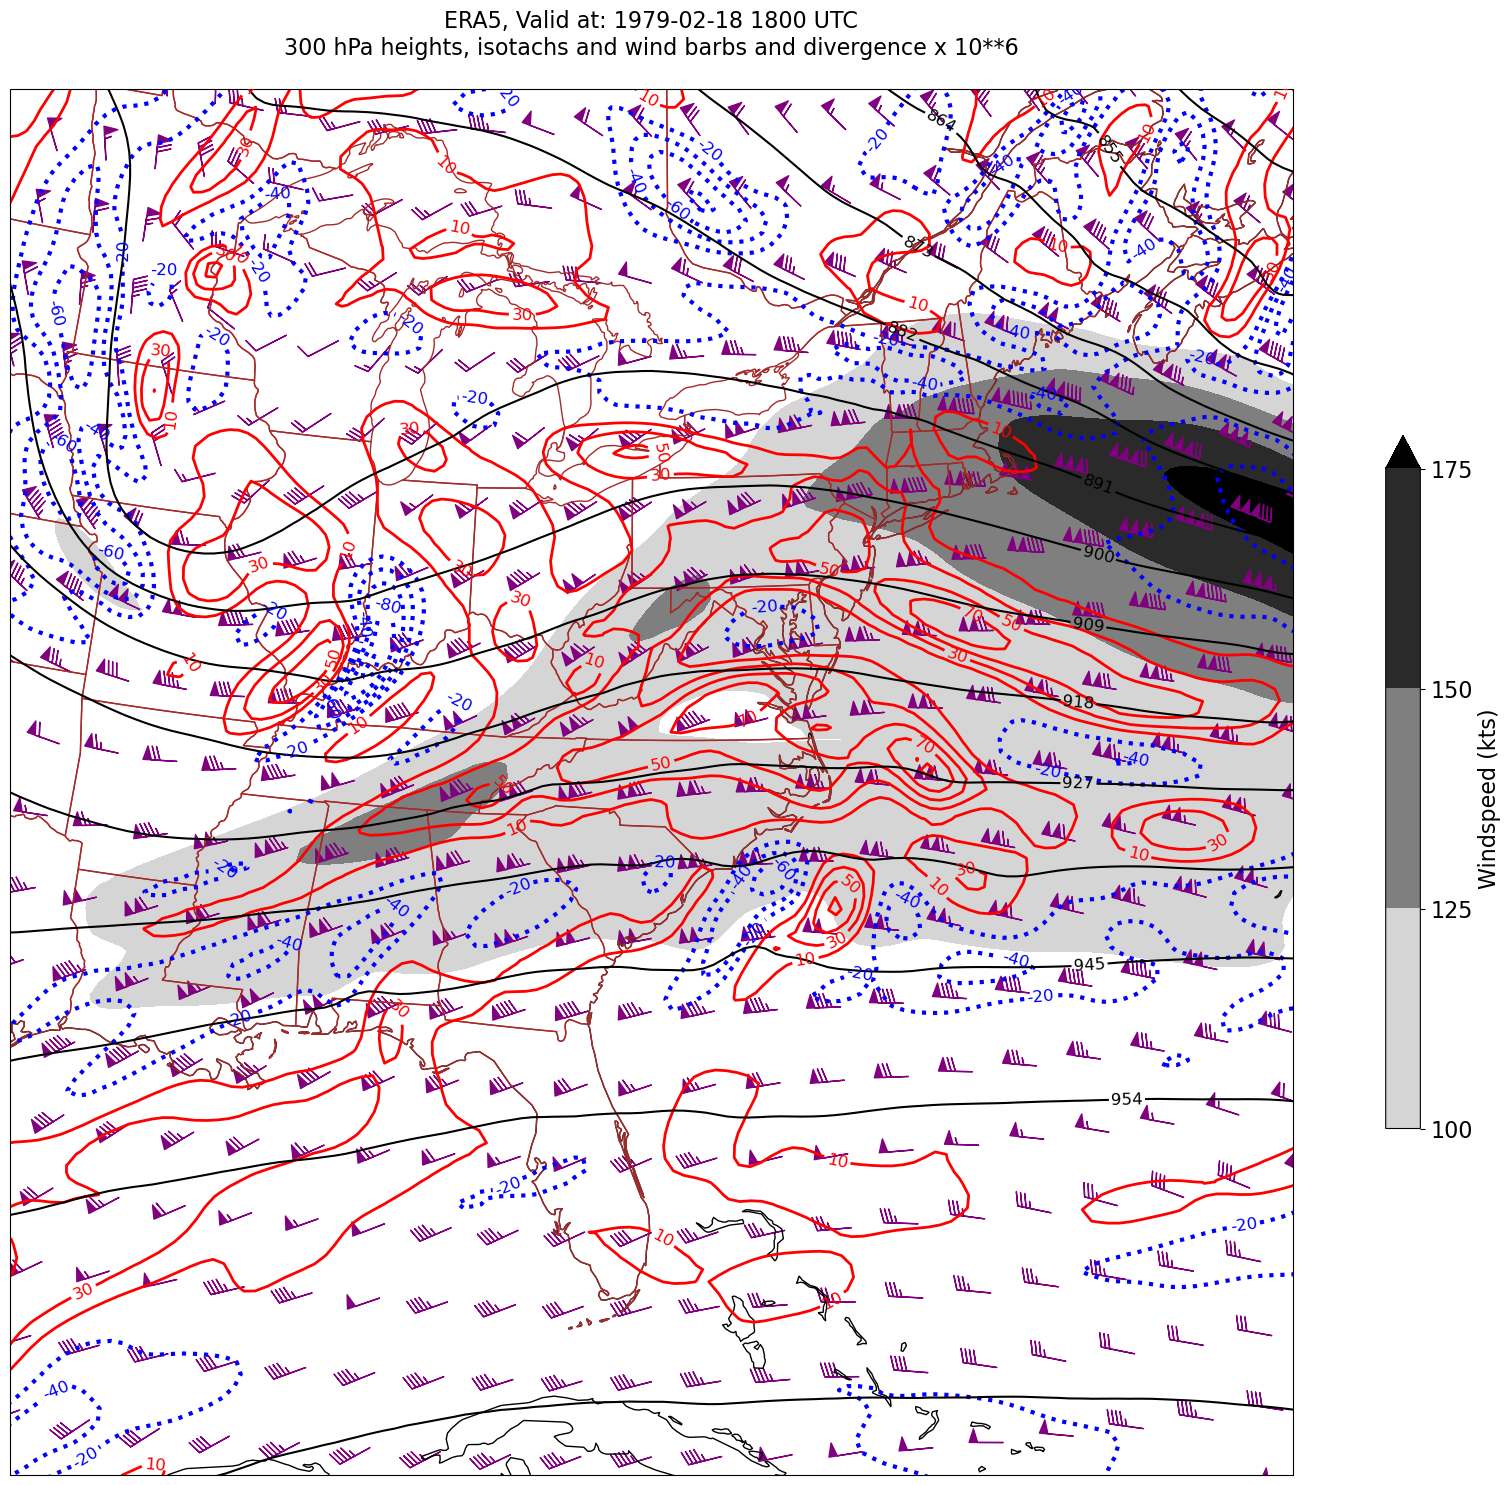

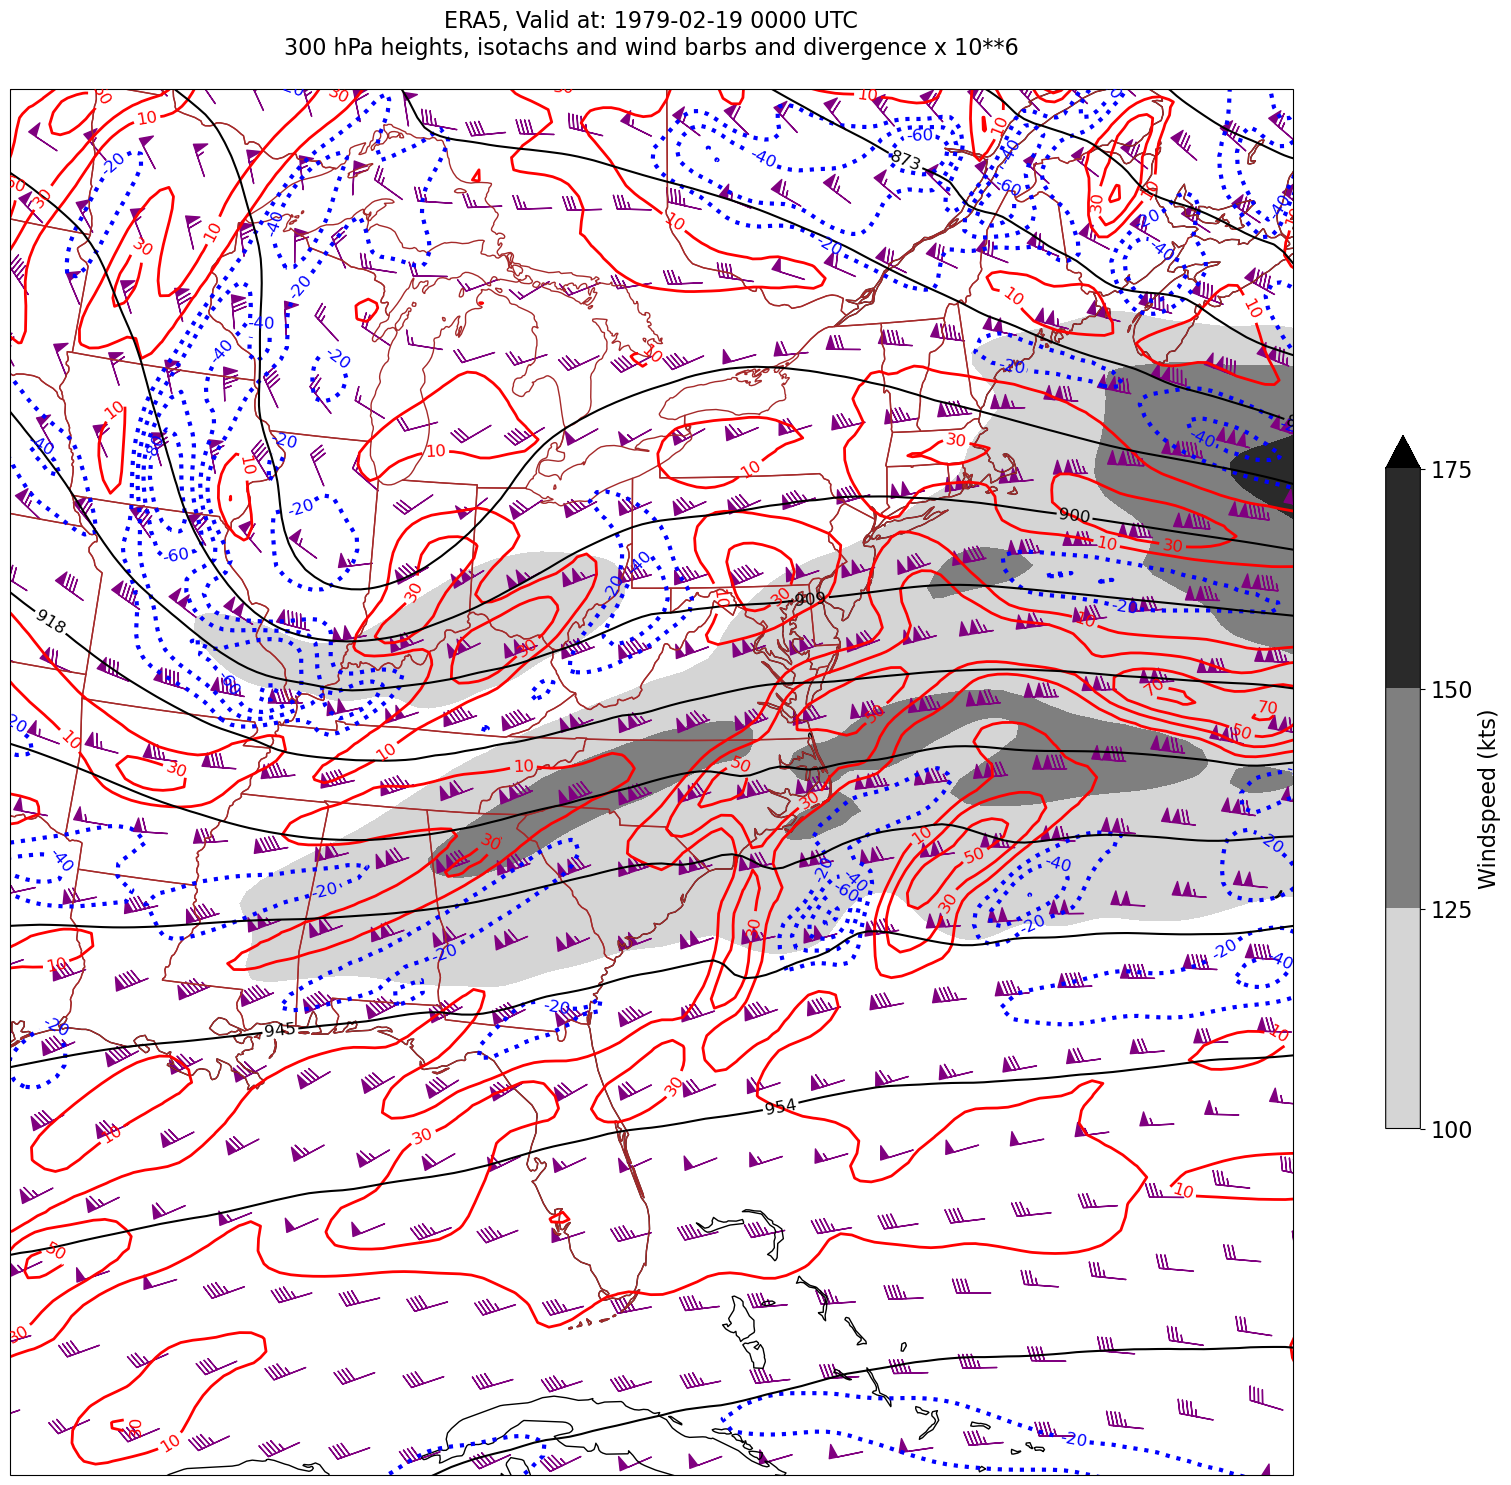

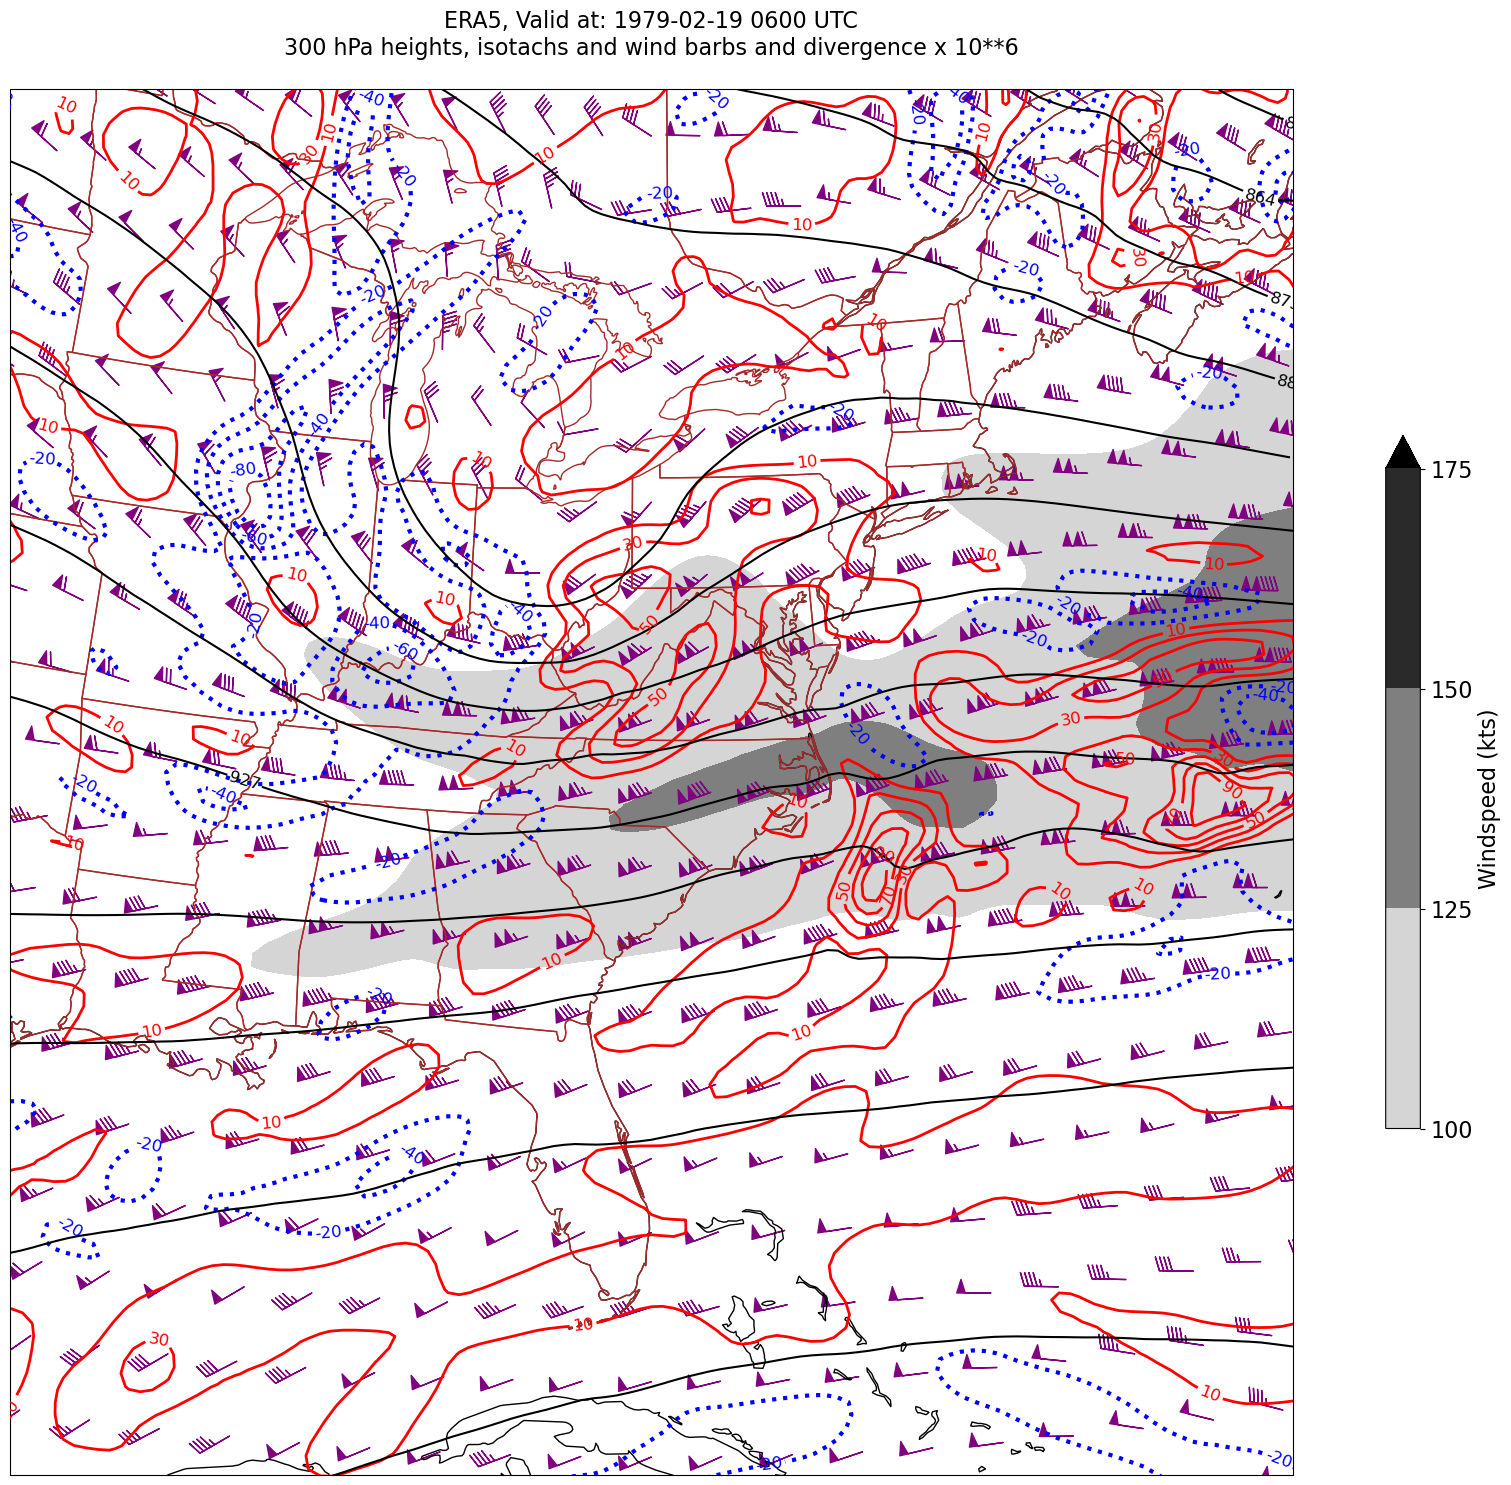

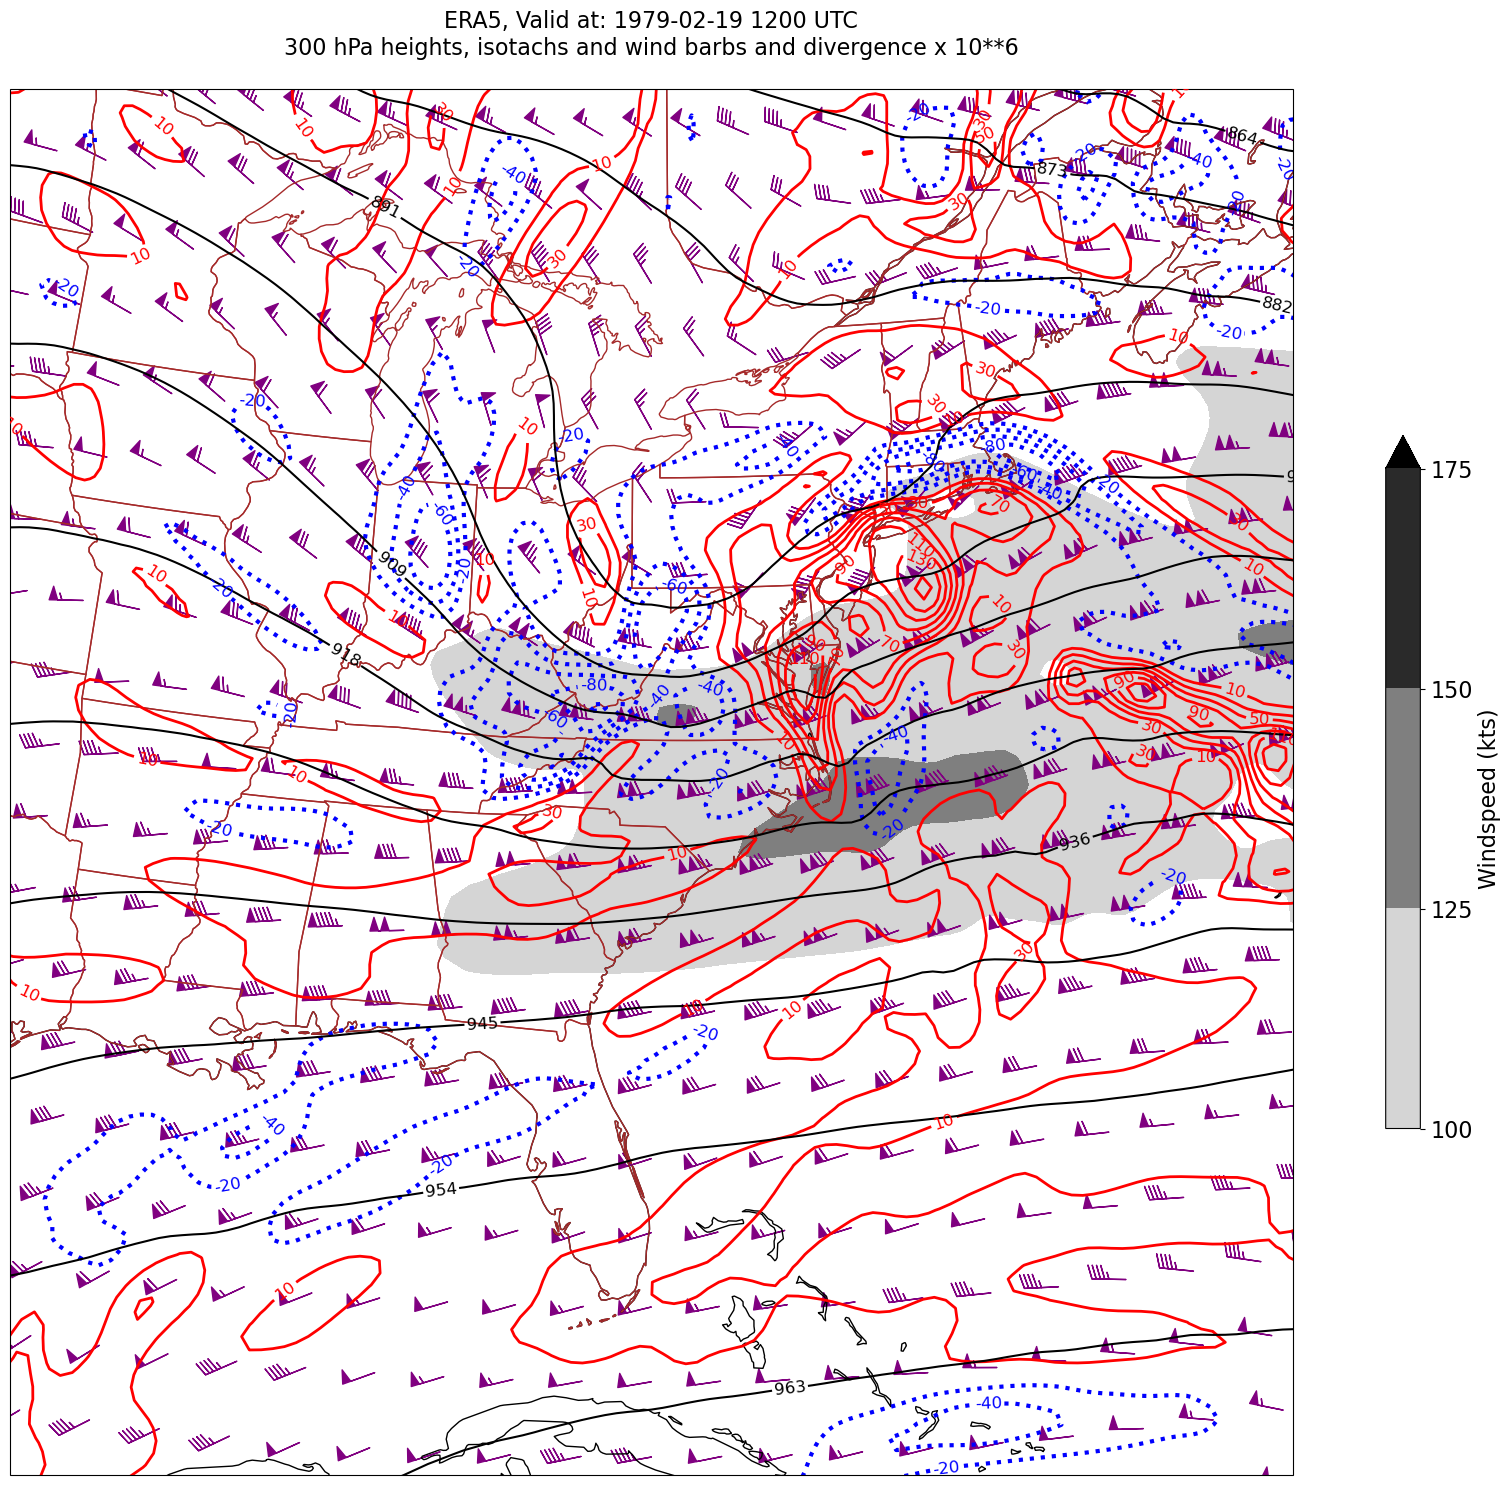

In [21]:
for time in dateList:
    print(f'Processing {time}')
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = f'ERA5, Valid at: {timeStr}'
    tl2 = f'{levStr} hPa heights, isotachs and wind barbs and divergence x 10**6'

    title_line = f'{tl1}\n{tl2}\n'
    
    fig = plt.figure(figsize=(24,18)) # Increase size to adjust for the constrained lats/lons
    ax = fig.add_subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    # 1. Contour fills of isotachs
    CF = ax.contourf(lons,lats,WSPD.sel(time=time),levels=wspdContours,transform=proj_data,cmap='gist_gray_r',extend='max')
    cbar = plt.colorbar(CF,shrink=0.5)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Windspeed (kts)",fontsize=16)

    # 2. Contour lines of divergence (first negative values, then positive)
    cDivNeg = ax.contour(lons, lats, divSmooth.sel(time=time), levels=negDivContours, colors='blue',linestyles='dotted',linewidths=3, transform=proj_data)
    ax.clabel(cDivNeg, inline=1, fontsize=12,fmt='%.0f')
    cDivPos = ax.contour(lons, lats, divSmooth.sel(time=time), levels=posDivContours, colors='red',linewidths=2, transform=proj_data)
    ax.clabel(cDivPos, inline=1, fontsize=12,fmt='%.0f')
    
    # 3. Contour lines of geopotential heights
    cZ = ax.contour(lons, lats, Z.sel(time=time), levels=zContours, colors='black', transform=proj_data)
    ax.clabel(cZ, inline=1, fontsize=12, fmt='%.0f')
    
    # 4. wind barbs
    # Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
    # Also need to sample (skip) a selected # of points to keep the plot readable.
    # Remember to use Xarray's sel method here as well to specify the current time.
    skip = 6
    ax.barbs(lons[::skip],lats[::skip],U.sel(time=time)[::skip,::skip].values, V.sel(time=time)[::skip,::skip].values, color='purple',transform=proj_data)

    title = ax.set_title(title_line,fontsize=16)
    
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = f'{timeStrFile}_ERA5_{levStr}_WndDivHght'
    fig.savefig(fileName)